# A 'Hello World' for PyTorch

PyTorch is a powerful machine learning library and is [becoming the dominant deep learning framework](https://www.assemblyai.com/blog/pytorch-vs-tensorflow-in-2022/). I want to learn how to use PyTorch, so in the spirit of "Hello World"-like programs, the first thing I wanted to do is create a small neural network and train it on an easy dataset. The [PyTorch tutorial](https://pytorch.org/tutorials/beginner/basics/buildmodel_tutorial.html) creates a fully connected neural network to train on FashionMNIST, but I want something even simpler so when things go wrong I'll know that I've made a mistake somewhere. 

For this experiment, I'll create a network of a few fully connected layers to classify the [two moons dataset](https://scikit-learn.org/stable/modules/generated/sklearn.datasets.make_moons.html). I've chosen this dataset because the data is easily visualized and the optimal decision boundary is both non-linear and obvious on inspection.

In [1]:
# Load libraries
import matplotlib.pyplot as plt
import numpy as np
from sklearn.datasets import make_moons

import torch
from torch import nn

In [2]:
# check that GPU is recognized
print("Does PyTorch recognize the GPU?","Yes" if torch.cuda.is_available() else "No")
device="cuda" if torch.cuda.is_available() else "cpu"

Does PyTorch recognize the GPU? Yes


## The Dataset: Two Moons

The first step is to investigate the toy dataset. The two moons dataset has one adjustable parameter, `noise`, which determines the spread of both half-moons. I've set `noise=0.1` so there are some values from each class that are very close at one end of each half moon. Even with this noise, the data appears separable such that a converged network should reach near 100% accuracy.

In [3]:
# Generate the Two Moons dataset
x_data, y_data = make_moons(
    n_samples=1000,
    shuffle=True,
    noise=0.1,
    random_state=42
)

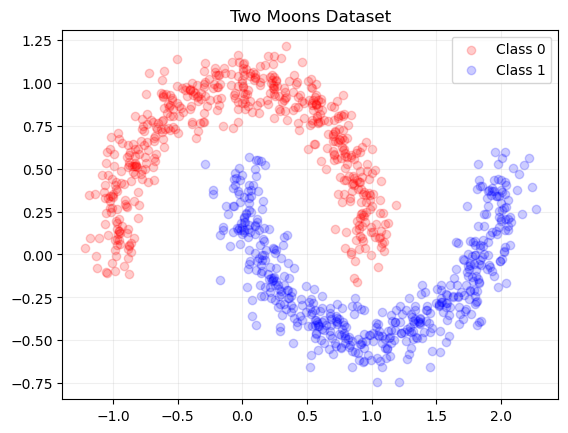

In [4]:
# Plot the Two Moons dataset
class_colors = ["red", "blue"]
for i in range(len(np.unique(y_data))):
    plt.scatter(
        x_data[y_data == i, 0],
        x_data[y_data == i, 1],
        color=class_colors[i],
        alpha=0.2,
        label="Class "+str(i)
    )

plt.grid(alpha=0.2)
plt.legend()
plt.title("Two Moons Dataset")
plt.show()

## Construct PyTorch Model and Dataset For Training

### Construct Network Graph

The simplest way to construct a neural network in PyTorch is with the [Sequential](https://pytorch.org/docs/master/generated/torch.nn.Sequential.html#torch.nn.Sequential) container and `torch.nn` modules. This is one of [three ways](https://h1ros.github.io/posts/3-ways-of-creating-a-neural-network-in-pytorch/) to construct a neural network in PyTorch. The network graph is defined by the order of the modules passed into `nn.Sequential`.

The below model takes in the x and y values of two moons data set then has three fully connected hidden layers, with 20, 20, and 20 nodes respectively. A [ReLU](https://pytorch.org/docs/stable/generated/torch.nn.ReLU.html) activation is used, followed by a [one dimensional batch normalization](https://pytorch.org/docs/stable/generated/torch.nn.BatchNorm1d.html). The final output could either be a [one-hot encoding](https://machinelearningmastery.com/why-one-hot-encode-data-in-machine-learning/) or a logistic regression to value where values greater than 0.5 are classified as 1 and values less than 0.5 are classified as 0 . I've chosen the logistic regression option.

In [5]:
# Define a neural network
model = nn.Sequential(
    nn.Linear(2, 20),
    nn.ReLU(),
    nn.BatchNorm1d(20),
    nn.Linear(20, 20),
    nn.ReLU(),
    nn.BatchNorm1d(20),
    nn.Linear(20, 20),
    nn.ReLU(),
    nn.BatchNorm1d(20),
    nn.Linear(20, 1),
    nn.Sigmoid()
)
model.to("cuda")
print(model)
print("Number of trainable parameters:", sum(p.numel()
      for p in model.parameters() if p.requires_grad))

Sequential(
  (0): Linear(in_features=2, out_features=20, bias=True)
  (1): ReLU()
  (2): BatchNorm1d(20, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (3): Linear(in_features=20, out_features=20, bias=True)
  (4): ReLU()
  (5): BatchNorm1d(20, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (6): Linear(in_features=20, out_features=20, bias=True)
  (7): ReLU()
  (8): BatchNorm1d(20, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (9): Linear(in_features=20, out_features=1, bias=True)
  (10): Sigmoid()
)
Number of trainable parameters: 1041


### Create Dataset and DataLoader

Next extend the `Dataset` class for the two moons dataset and create a `DataLoader` object. The extension of `Dataset` class must define a `__len__` function which returns the number of samples and a `__getitem__` function which returns an instance given an index. The `DataLoader` is a utility for iterating over the dataset. I've defined the minibatch size as 100, which is 10% of the 1000 instances of the two moons dataset. An enumerated `DataLoader` will provide one batch per iteration.

In [6]:
class TwoMoons(torch.utils.data.Dataset):
    def __init__(self, x_data, y_data):
        self.X = torch.from_numpy(x_data).to(device)
        self.Y = torch.from_numpy(y_data).to(device)

    def __len__(self):
        return len(self.Y)

    def __getitem__(self, idx):
        return [self.X[idx], self.Y[idx]]

In [7]:
# Create the training data as a DataLoader Object
two_moons = TwoMoons(x_data, y_data)
train_data = torch.utils.data.DataLoader(two_moons, batch_size=100)

### Define Objective Function and Optimizer

To train a network, a loss/objective function needs to be defined. This is the mathematical function which the network is trying to minimize. Since the above network is a regression problem, a mean squared error loss `MSELoss()` is an appropriate choice. This loss is minimized by the optimization algorithm, which takes the current predictions of the network and updates the model parameters. PyTorch has [many optimization algorithms](https://pytorch.org/docs/stable/optim.html), but I've used stochastic gradient descent or [`SGD`](https://pytorch.org/docs/stable/generated/torch.optim.SGD.html#torch.optim.SGD).

In [8]:
# Define Loss Function and Optimizer
loss_function = nn.MSELoss()
optimizer = torch.optim.SGD(model.parameters(), lr=1e-1, momentum=0.9)

### Weight Initialization

 Parameters in the network are initialized with reasonable defaults determined by PyTorch. For example, the `nn.Linear` module's parameters are [initialized](https://pytorch.org/docs/stable/generated/torch.nn.Linear.html) from a uniform distribution (-$\sqrt{k}$,$\sqrt{k}$), where $k$ is the inverse of the number of input features to the layer. When training a network, the trainable parameters will change as the network learns. I found it helpful to be able to reset all the weights when experimenting, especially in combination with setting the default random seed. Resetting the network weights can be achieved by the `reset_parameters()` method for trainable modules (in this case the `nn.Linear` and `nn.BatchNorm1d` layers). By using the apply method of the `Sequential` container, the weights of each layer can be reset with below function:

In [9]:
def init_weights(model):
    def reset_weights(m):
        if isinstance(m,nn.Linear) or isinstance(m,nn.BatchNorm1d):
            m.reset_parameters()
    model.apply(reset_weights)
    

## Train the Model

With a network, loss function, optimization method, and a way to handle the data, we can begin to train the network. This is divided into two main steps, initialization and training. 

1. Initialization
    - __Determine how long to train.__ In this case, I train for 10 epochs. Alternatively could train until certain loss is achieved. An epoch is a full pass through the training data. Based upon how I set up the `DataLoader`, one epoch consists of 10 mini-batches. In each mini-batch, a noisy estimate of the loss (noisy since only calculated on a fraction of the training data) is calculated and used to update the model weights. Many machine learning tasks are non-convex optimization problems, [where a noisy estimate of the loss often outperforms the true loss](https://datascience.stackexchange.com/questions/16807/why-mini-batch-size-is-better-than-one-single-batch-with-all-training-data) since it can escape local minima in the loss function.
    - __Set the random seed.__ When things go wrong, it is helpful to remove the RNG from what is happening. Each random seed will give different initial weights to the network and therefore different initial accuracy+decision boundary.
    - __Initial performance of Model.__ With weights initialized, test the accuracy of the model. On average expect this to be around 50% for binary classification, but will be off based on network architecture and initial weights.
    
2. Training
    - __Zero the gradients.__ By default the [gradients are accumulated in a buffer](https://pytorch.org/tutorials/recipes/recipes/zeroing_out_gradients.html), so need to zero them out so back propagation is calculated correctly. 
    - __Make prediction and calculate loss.__ Network output is calculated by passing the input values directly to the model object. These predictions and the true values are then passed to the loss function, giving the loss for the mini-batch. 
    - __Back Propagation.__ With a loss, we can calculate the gradient of the network with [`.backward()`](https://pytorch.org/docs/stable/generated/torch.Tensor.backward.html). After the gradient is calculated, the optimizer can update the weights of the network with the [`.step()`](https://pytorch.org/docs/stable/generated/torch.optim.Optimizer.step.html) method.


In [16]:
# 1. Initialization
num_epochs = 10

torch.manual_seed(42)
init_weights(model)

loss_history = np.zeros((num_epochs))
accuracy_history = np.zeros((num_epochs))

initial_preds = model(two_moons.X.float())
initial_loss = loss_function(initial_preds, two_moons.Y.unsqueeze(1).float())
initial_acc = torch.eq(initial_preds.squeeze(
    1).round().bool(), two_moons.Y.bool()).sum()

print(f"Initial Loss: {initial_loss}")
print(f"Initial Accuracy: {initial_acc/len(two_moons)} \n")

#2. Learning
for epoch in range(num_epochs):
    running_loss = 0
    num_correct = 0
    total_samples = 0
    for i, (inputs, targets) in enumerate(train_data):
        optimizer.zero_grad()
        predictions = model(inputs.float())
        loss = loss_function(predictions, targets.unsqueeze(1).float())
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        num_correct += torch.eq(predictions.squeeze(1).round().bool(),
                                targets.bool()).sum()
        total_samples += targets.size(0)

    loss_history[epoch] = running_loss/len(train_data)
    accuracy_history[epoch] = num_correct/total_samples

    print(
        f"Epoch: {epoch+1:02d}/{num_epochs} | Loss: {loss_history[epoch]:.5f} \t | Accuracy: {accuracy_history[epoch]:.5f}")

Initial Loss: 0.25068870186805725
Initial Accuracy: 0.5560000538825989 

Epoch: 01/10 | Loss: 0.09092 	 | Accuracy: 0.88900
Epoch: 02/10 | Loss: 0.01654 	 | Accuracy: 0.98800
Epoch: 03/10 | Loss: 0.00792 	 | Accuracy: 0.99200
Epoch: 04/10 | Loss: 0.00350 	 | Accuracy: 0.99700
Epoch: 05/10 | Loss: 0.00244 	 | Accuracy: 0.99800
Epoch: 06/10 | Loss: 0.00178 	 | Accuracy: 0.99800
Epoch: 07/10 | Loss: 0.00155 	 | Accuracy: 1.00000
Epoch: 08/10 | Loss: 0.00136 	 | Accuracy: 0.99900
Epoch: 09/10 | Loss: 0.00119 	 | Accuracy: 1.00000
Epoch: 10/10 | Loss: 0.00133 	 | Accuracy: 0.99800


## Inspect Model Results

In addition to training, I've kept track of the model accuracy (correct predictions) and the model loss (mean squared error) across each epoch. The network converges to an optimal solution very quickly, reaching 98.8% accuracy after just two epochs. 

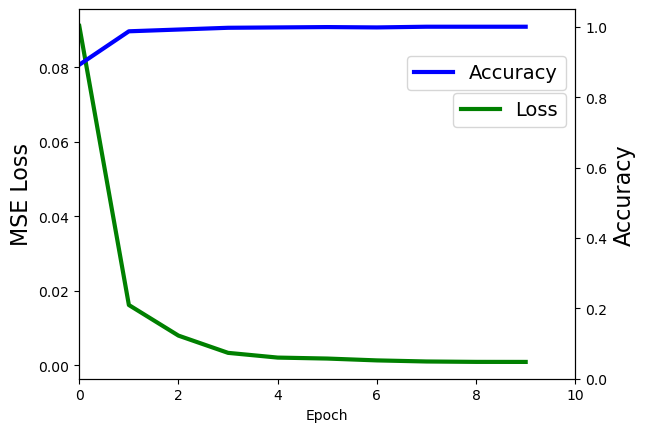

In [15]:
# Plot the Loss History and the Accuracy
# Plot the Loss and Accuracy History
fig, ax1 = plt.subplots()
ax2 = ax1.twinx()
ax1.plot(range(num_epochs), loss_history, 'g-', linewidth=3, label="Loss")
ax2.plot(range(num_epochs), accuracy_history,
         'b-', linewidth=3, label="Accuracy")
ax1.set_xlabel("Epoch")
ax1.set_ylabel("MSE Loss", fontsize=16)
ax2.set_ylabel("Accuracy", fontsize=16)
ax2.set_ylim([0, 1.05])
ax1.set_xlim([0, 10])
ax1.legend(bbox_to_anchor=(1, 0.8), fontsize=14)
ax2.legend(bbox_to_anchor=(1, 0.9), fontsize=14)

Additionally, by making predictions for a grid of points, we can visualize the decision boundary learned by the network. I've found that the decision boundary between regions where there is training data is similar across random seeds. However, the decision boundary outside of this distribution changes based on the random seed/initial state of the network. This highlights a (potential) weakness of neural nets, as [they can perform poorly on data out of their training distribution](https://ai.googleblog.com/2019/12/improving-out-of-distribution-detection.html). 

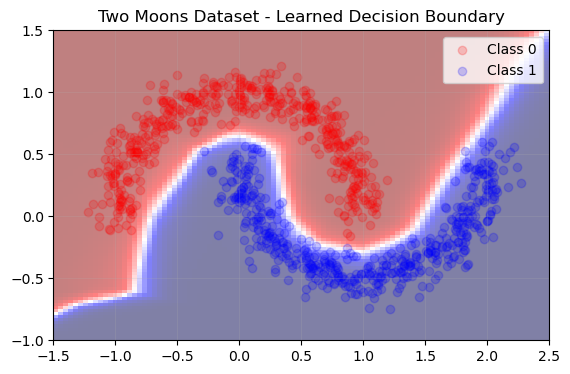

In [17]:
# Plot the scatter plot and the decision boundary

x0_grid = np.linspace(-1.5, 2.5, num=100)
x1_grid = np.linspace(-1, 1.5, num=100)

pred_grid = torch.from_numpy(np.array(np.meshgrid(x0_grid, x1_grid)))
pred_grid = pred_grid.to("cuda")
pred_array = torch.transpose(
    torch.reshape(pred_grid, (2, pred_grid.shape[1]*pred_grid.shape[2])), 0, 1
)


def makeGridPrediction(model, pred_array):
    model_array_preds = model(pred_array.float())

    model_grid_preds = torch.flip(
        torch.reshape(
            torch.transpose(model_array_preds, 0, 1),
            (pred_grid.shape[1], pred_grid.shape[2])
        ),
        [0])

    return model_grid_preds.cpu().detach().numpy()


plt.imshow(
    makeGridPrediction(model, pred_array),
    extent=[x0_grid[0], x0_grid[-1], x1_grid[0], x1_grid[-1]],
    cmap='seismic_r',
    alpha=0.5)

# Plot the data again
class_colors = ["red", "blue"]
for i in range(len(np.unique(y_data))):
    plt.scatter(
        x_data[y_data == i, 0],
        x_data[y_data == i, 1],
        color=class_colors[i],
        alpha=0.2,
        label="Class "+str(i)
    )

plt.grid(alpha=0.2)
plt.legend()
plt.title("Two Moons Dataset - Learned Decision Boundary")
plt.show()